# Football Team Detection - Long Video (Optimized)

This notebook is optimized for processing longer videos (7+ minutes) on CPU by using frame sampling and other performance optimizations.

**Key Optimizations:**
- Frame sampling: Process every 5th frame for embeddings (5x speedup)
- Smaller crop size: 128x128 instead of 224x224 for faster SigLip processing
- Maximum detections per frame: Limit to prevent memory issues
- Caching: Reuse embeddings across runs

In [1]:
# --- 1) Enhanced Imports & Config (Optimized for Long Videos) ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
import base64
from io import BytesIO
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pickle
import os
import warnings
import time

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UserWarning, module='umap')

# CONFIG - OPTIMIZED FOR LONG VIDEOS
VIDEO_PATH = 'videos/sample.mp4'  # 7-minute video
MODEL_PATH = 'yolov8n.pt'
CONF_THRESH = 0.3
EMBEDDINGS_CACHE = 'embeddings_cache_long_resnet.pkl'  # New cache name

# PERFORMANCE OPTIMIZATIONS
FRAME_SAMPLING_RATE = 5  # Process every 5th frame (5x speedup)
MAX_DETECTIONS_PER_FRAME = 20  # Limit detections to avoid memory issues
CROP_SIZE = 224  # ResNet expects 224x224

print(f"Configuration:")
print(f"  Video: {VIDEO_PATH}")
print(f"  Embedding model: ResNet50 (much faster than SigLip!)")
print(f"  Frame sampling: Every {FRAME_SAMPLING_RATE} frames")
print(f"  Crop size: {CROP_SIZE}x{CROP_SIZE}")
print(f"  Max detections/frame: {MAX_DETECTIONS_PER_FRAME}")

# Load ResNet50 for embeddings (MUCH FASTER than SigLip)
print("\nLoading ResNet50 model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("⚠️ CPU mode - but ResNet50 is still 10-15x faster than SigLip!")

# Load pre-trained ResNet50
resnet_model = models.resnet50(pretrained=True)
# Remove the final classification layer to get embeddings
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])
resnet_model.to(device)
resnet_model.eval()

# ResNet preprocessing
resnet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"✓ ResNet50 loaded on {device}")
print(f"✓ Output: 2048-dimensional embeddings (vs SigLip's 768)")

Configuration:
  Video: videos/sample.mp4
  Embedding model: ResNet50 (much faster than SigLip!)
  Frame sampling: Every 5 frames
  Crop size: 224x224
  Max detections/frame: 20

Loading ResNet50 model...
Using device: cpu
⚠️ CPU mode - but ResNet50 is still 10-15x faster than SigLip!


c:\Users\pavle\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pavle\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\pavle/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:13<00:00, 7.47MB/s]



✓ ResNet50 loaded on cpu
✓ Output: 2048-dimensional embeddings (vs SigLip's 768)


In [2]:
# --- 2) Enhanced Helper Functions ---
def get_resnet_embedding(image):
    """Create embedding using ResNet50 - MUCH faster than SigLip"""
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)
    
    # Apply ResNet preprocessing
    img_tensor = resnet_transform(pil_img).unsqueeze(0).to(device)
    
    # Get embeddings
    with torch.no_grad():
        embedding = resnet_model(img_tensor)
        embedding = embedding.squeeze().cpu().numpy()
    
    return embedding

def crop_player(frame, x1, y1, x2, y2):
    """Simple crop with bounds checking"""
    h, w = frame.shape[:2]
    x1, y1, x2, y2 = max(0, int(x1)), max(0, int(y1)), min(w, int(x2)), min(h, int(y2))
    
    if x2 <= x1 or y2 <= y1:
        return None
    
    return frame[y1:y2, x1:x2]

def format_time(seconds):
    """Format seconds into MM:SS"""
    mins = int(seconds // 60)
    secs = int(seconds % 60)
    return f"{mins}:{secs:02d}"

print("✓ Helper functions loaded with ResNet50")

✓ Helper functions loaded with ResNet50


In [3]:
# --- 3) Enhanced Detection with Frame Sampling ---

# Check if embeddings cache exists
if os.path.exists(EMBEDDINGS_CACHE):
    print(f"Loading embeddings from cache: {EMBEDDINGS_CACHE}")
    start_time = time.time()
    with open(EMBEDDINGS_CACHE, 'rb') as f:
        cache_data = pickle.load(f)
        all_crops = cache_data['crops']
        all_embeddings = cache_data['embeddings']
        ball_crops = cache_data['ball_crops']
        frame_count = cache_data['frame_count']
        video_width = cache_data['video_width']
        video_height = cache_data['video_height']
        detection_metadata = cache_data.get('detection_metadata', [])
    
    load_time = time.time() - start_time
    print(f"✓ Loaded in {load_time:.1f}s")
    print(f"  {len(all_crops)} person detections")
    print(f"  {len(ball_crops)} ball detections")
    print(f"  {len(detection_metadata)} metadata entries")
    
    if not detection_metadata:
        print("⚠️ Warning: Old cache format detected")
        os.remove(EMBEDDINGS_CACHE)
        print("Please rerun this cell to regenerate the cache.")
        import sys
        sys.exit("Cache regeneration needed")
else:
    print("No cache found, processing video...")
    start_time = time.time()
    
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print(f"Error: Could not open video {VIDEO_PATH}")
        exit()

    # Get video info
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Video info:")
    print(f"  Duration: {format_time(duration)} ({total_frames} frames @ {fps:.1f} FPS)")
    print(f"  Resolution: {video_width}x{video_height}")
    print(f"  Frames to process: {total_frames // FRAME_SAMPLING_RATE} (every {FRAME_SAMPLING_RATE}th)")
    
    model = YOLO(MODEL_PATH)

    # Storage
    all_crops = []
    all_embeddings = []
    ball_crops = []
    detection_metadata = []
    frame_count = 0
    processed_count = 0

    print("\nProcessing video with ResNet50 embeddings (fast!)...")
    last_print_time = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Frame sampling
        if frame_count % FRAME_SAMPLING_RATE != 0:
            frame_count += 1
            continue
        
        # Detect objects
        results = model(frame, conf=CONF_THRESH, verbose=False)
        
        frame_detections = 0
        
        # Process detections
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    if frame_detections >= MAX_DETECTIONS_PER_FRAME:
                        break
                    
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cls = int(box.cls)
                    conf = float(box.conf)
                    
                    # Process persons
                    if cls == 0:
                        width = x2 - x1
                        height = y2 - y1
                        area = width * height
                        aspect_ratio = height / width if width > 0 else 0
                        
                        center_x = (x1 + x2) / 2
                        center_y = (y1 + y2) / 2
                        
                        # Filters
                        if (center_x > video_width * 0.75 and center_y < video_height * 0.25):
                            continue
                        
                        if (area < 2000 or area > 50000 or
                            aspect_ratio < 1.2 or aspect_ratio > 4.0 or
                            width < 30 or height < 50 or
                            x1 < 10 or y1 < 10 or
                            x2 > video_width - 10 or y2 > video_height - 10):
                            continue
                        
                        if area < 3000 and center_y < video_height * 0.3:
                            continue
                        
                        # Crop player
                        crop = crop_player(frame, x1, y1, x2, y2)
                        if crop is not None:
                            # Get ResNet50 embedding (MUCH FASTER!)
                            embedding = get_resnet_embedding(crop)
                            all_crops.append(crop)
                            all_embeddings.append(embedding)
                            detection_metadata.append({
                                'frame_idx': frame_count,
                                'bbox': (x1, y1, x2, y2),
                                'detection_idx': len(all_crops) - 1
                            })
                            frame_detections += 1
                    
                    # Process sports ball
                    elif cls == 32:
                        width = x2 - x1
                        height = y2 - y1
                        area = width * height
                        
                        if area > 50 and area < 2000 and conf > 0.5:
                            crop = crop_player(frame, x1, y1, x2, y2)
                            if crop is not None:
                                ball_crops.append(crop)
        
        processed_count += 1

        # Progress update every 30 seconds (more frequent since it's faster)
        if time.time() - last_print_time > 30:
            elapsed = time.time() - start_time
            progress = frame_count / total_frames
            eta = (elapsed / progress - elapsed) if progress > 0 else 0
            print(f"  Frame {frame_count}/{total_frames} ({progress*100:.1f}%) - "
                  f"{len(all_crops)} people - Elapsed: {format_time(elapsed)} - ETA: {format_time(eta)}")
            last_print_time = time.time()
        
        frame_count += 1

    cap.release()
    total_time = time.time() - start_time
    
    print(f"\n✓ Processing complete!")
    print(f"  Total time: {format_time(total_time)}")
    print(f"  Frames processed: {processed_count} / {total_frames} (sampled every {FRAME_SAMPLING_RATE})")
    print(f"  Person detections: {len(all_crops)}")
    print(f"  Ball detections: {len(ball_crops)}")
    print(f"  Avg time per sampled frame: {total_time/processed_count:.2f}s")
    print(f"  ResNet50 speed: ~{processed_count/(total_time/60):.1f} frames/min")
    
    # Save embeddings to cache
    print(f"\nSaving embeddings to cache: {EMBEDDINGS_CACHE}")
    cache_data = {
        'crops': all_crops,
        'embeddings': all_embeddings,
        'ball_crops': ball_crops,
        'frame_count': frame_count,
        'video_width': video_width,
        'video_height': video_height,
        'detection_metadata': detection_metadata
    }
    with open(EMBEDDINGS_CACHE, 'wb') as f:
        pickle.dump(cache_data, f)
    print("✓ Cache saved successfully!")

No cache found, processing video...
Video info:
  Duration: 7:50 (14109 frames @ 30.0 FPS)
  Resolution: 1920x1080
  Frames to process: 2821 (every 5th)
Video info:
  Duration: 7:50 (14109 frames @ 30.0 FPS)
  Resolution: 1920x1080
  Frames to process: 2821 (every 5th)

Processing video with ResNet50 embeddings (fast!)...

Processing video with ResNet50 embeddings (fast!)...
  Frame 70/14109 (0.5%) - 14 people - Elapsed: 0:38 - ETA: 127:32
  Frame 70/14109 (0.5%) - 14 people - Elapsed: 0:38 - ETA: 127:32
  Frame 115/14109 (0.8%) - 122 people - Elapsed: 1:08 - ETA: 138:36
  Frame 115/14109 (0.8%) - 122 people - Elapsed: 1:08 - ETA: 138:36
  Frame 175/14109 (1.2%) - 279 people - Elapsed: 1:40 - ETA: 132:42
  Frame 175/14109 (1.2%) - 279 people - Elapsed: 1:40 - ETA: 132:42
  Frame 230/14109 (1.6%) - 420 people - Elapsed: 2:12 - ETA: 133:30
  Frame 230/14109 (1.6%) - 420 people - Elapsed: 2:12 - ETA: 133:30
  Frame 265/14109 (1.9%) - 520 people - Elapsed: 2:43 - ETA: 141:55
  Frame 265/14

Clustering 18872 detections...
Embedding dimension: 2048
Applying UMAP dimensionality reduction...
Applying UMAP dimensionality reduction...
UMAP complete in 43.7s
Running K-Means clustering (k=3)...
UMAP complete in 43.7s
Running K-Means clustering (k=3)...

Cluster sizes: [np.int64(8818), np.int64(8329), np.int64(1725)]
  Cluster 0: 8329 people (44.1%)
  Cluster 1: 8818 people (46.7%)
  Cluster 2: 1725 people (9.1%)

Team Identification:
  Cluster 1: TEAM 1 (8818 players)
  Cluster 0: TEAM 2 (8329 players)
  Cluster 2: REFEREE (1725 people)

Cluster sizes: [np.int64(8818), np.int64(8329), np.int64(1725)]
  Cluster 0: 8329 people (44.1%)
  Cluster 1: 8818 people (46.7%)
  Cluster 2: 1725 people (9.1%)

Team Identification:
  Cluster 1: TEAM 1 (8818 players)
  Cluster 0: TEAM 2 (8329 players)
  Cluster 2: REFEREE (1725 people)


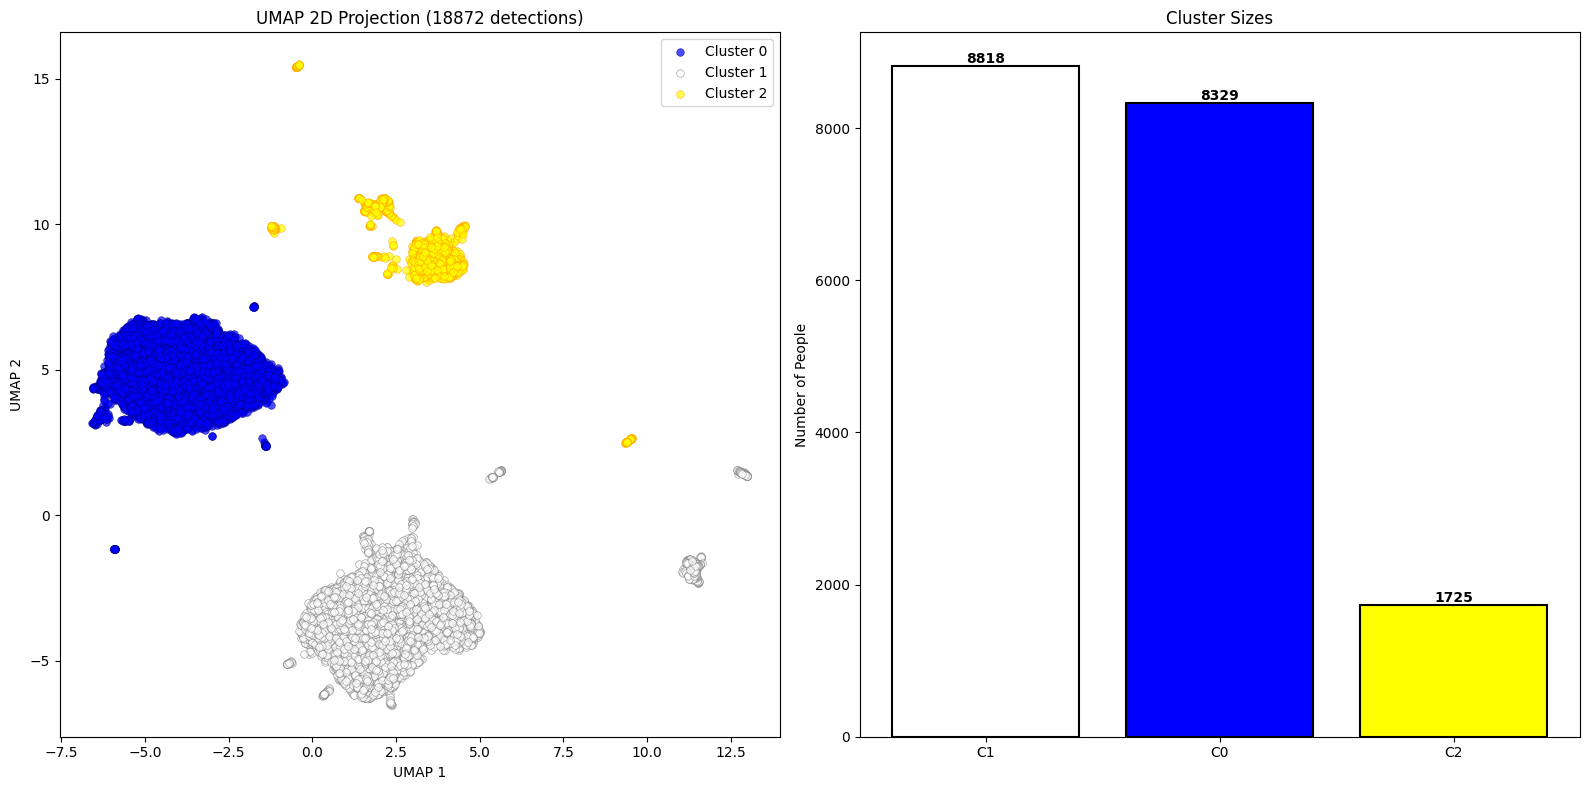

In [4]:
# --- 4) UMAP + Clustering ---
if len(all_embeddings) < 10:
    print("Not enough people detected for clustering")
else:
    embeddings_array = np.array(all_embeddings) 
    print(f"Clustering {len(all_embeddings)} detections...")
    print(f"Embedding dimension: {embeddings_array.shape[1]}")
    
    # Standardize
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings_array)
    
    # UMAP
    print("Applying UMAP dimensionality reduction...")
    umap_start = time.time()
    umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, n_jobs=1)
    embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)
    print(f"UMAP complete in {time.time()-umap_start:.1f}s")
    
    # K-Means
    print("Running K-Means clustering (k=3)...")
    best_k = 3
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
    team_labels = kmeans.fit_predict(embeddings_2d)
    
    # Analysis
    unique, counts = np.unique(team_labels, return_counts=True)
    sorted_counts = sorted(counts, reverse=True)
    
    print(f"\nCluster sizes: {sorted_counts}")
    
    cluster_info = []
    for i in range(best_k):
        cluster_mask = team_labels == i
        cluster_size = sum(cluster_mask)
        percentage = cluster_size / len(all_embeddings) * 100
        cluster_info.append({
            'id': i,
            'size': cluster_size,
            'percentage': percentage
        })
        print(f"  Cluster {i}: {cluster_size} people ({percentage:.1f}%)")
    
    cluster_info.sort(key=lambda x: x['size'], reverse=True)
    
    print("\nTeam Identification:")
    for i, info in enumerate(cluster_info):
        if i == 0:
            print(f"  Cluster {info['id']}: TEAM 1 ({info['size']} players)")
        elif i == 1:
            print(f"  Cluster {info['id']}: TEAM 2 ({info['size']} players)")
        else:
            print(f"  Cluster {info['id']}: REFEREE ({info['size']} people)")
    
    # Visualization
    fig = plt.figure(figsize=(16, 8))
    
    ax1 = plt.subplot(1, 2, 1)
    colors = ['blue', 'white', 'yellow']
    edge_colors = ['darkblue', 'gray', 'orange']
    
    for i in range(best_k):
        cluster_mask = team_labels == i
        cluster_points = embeddings_2d[cluster_mask]
        ax1.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   c=colors[i], alpha=0.7, s=30,
                   edgecolors=edge_colors[i], linewidth=0.5,
                   label=f'Cluster {i}')
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    ax1.set_title(f'UMAP 2D Projection ({len(all_embeddings)} detections)')
    ax1.legend()
    
    ax2 = plt.subplot(1, 2, 2)
    cluster_sizes = [info['size'] for info in cluster_info]
    cluster_ids = [f"C{info['id']}" for info in cluster_info]
    bar_colors = [colors[info['id']] for info in cluster_info]
    bars = plt.bar(cluster_ids, cluster_sizes, color=bar_colors, edgecolor='black', linewidth=1.5)
    plt.title('Cluster Sizes')
    plt.ylabel('Number of People')
    for bar, size in zip(bars, cluster_sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(size), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# --- 4.5) Interactive UMAP with Hover Preview ---
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import cv2

# Build interactive scatter plot as a FigureWidget
figw = go.FigureWidget()

color_map = {0: 'blue', 1: 'lightgray', 2: 'yellow'}
traces = []

for i in range(best_k):
    cluster_mask = (team_labels == i)
    cluster_points = embeddings_2d[cluster_mask]
    cluster_indices = np.where(cluster_mask)[0]

    # Store original crop index in customdata
    customdata = np.array(cluster_indices).reshape(-1, 1)

    traces.append(go.Scatter(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        mode='markers',
        name=f'Cluster {i}',
        marker=dict(size=8, color=color_map.get(i, 'gray'),
                    line=dict(width=1, color='black')),
        customdata=customdata,
        hovertemplate='Cluster: '+str(i)+'<br>UMAP1: %{x:.3f}<br>UMAP2: %{y:.3f}<extra></extra>'
    ))

for t in traces:
    figw.add_trace(t)

figw.update_layout(
    title='UMAP 2D Projection — hover a point to preview its crop',
    xaxis_title='UMAP 1',
    yaxis_title='UMAP 2',
    width=900,
    height=650,
    hovermode='closest',
    template='plotly_white'
)

# Preview pane on the right
preview = widgets.Output(layout={'border': '1px solid #444', 'width': '260px', 'height': '260px'})
caption = widgets.HTML("<b>Hover preview</b><br><span style='color:#888'>(move the mouse over a point)</span>")

box = widgets.HBox([figw, widgets.VBox([caption, preview])])
display(box)

# Hover callbacks: show the crop in the preview pane
def make_hover_handler(trace):
    def _on_hover(trace, points, state):
        with preview:
            preview.clear_output(wait=True)
            if not points.point_inds:
                return
            # Recover the original index into all_crops from customdata
            local_idx = points.point_inds[0]
            global_idx = int(trace.customdata[local_idx][0])

            crop_bgr = all_crops[global_idx]
            crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
            crop_rgb = cv2.resize(crop_rgb, (224, 224), interpolation=cv2.INTER_AREA)
            display(Image.fromarray(crop_rgb))
    return _on_hover

def make_unhover_handler(trace):
    def _on_unhover(trace, points, state):
        # Optionally clear preview when leaving a point
        pass
    return _on_unhover

for tr in figw.data:
    tr.on_hover(make_hover_handler(tr))
    tr.on_unhover(make_unhover_handler(tr))

print("✓ Interactive UMAP visualization ready!")
print("  Hover over any point to see the player crop")
print("  This is useful for examining outliers and verifying cluster assignments")

c:\Users\pavle\AppData\Local\Programs\Python\Python313\Lib\site-packages\kaleido\_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




    'data': [{'customdata': {'bdata': ('AAACAAMABgAIAAkADQAPABEAEgATAB' ... 'pJn…

✓ Interactive UMAP visualization ready!
  Hover over any point to see the player crop
  This is useful for examining outliers and verifying cluster assignments


In [5]:
# --- 5) Annotate Video ---
print("Creating annotated video...")

# Build frame mapping
frame_detections = {}
for i, metadata in enumerate(detection_metadata):
    frame_idx = metadata['frame_idx']
    if frame_idx not in frame_detections:
        frame_detections[frame_idx] = []
    
    cluster = team_labels[i]
    frame_detections[frame_idx].append({
        'bbox': metadata['bbox'],
        'cluster': cluster
    })

print(f"Mapped {len(detection_metadata)} detections across {len(frame_detections)} frames")

# For long videos, apply clusters to all frames (not just sampled ones)
# by using the nearest sampled frame's detections
def get_nearest_sampled_frame(frame_idx, sampled_frames):
    """Find nearest sampled frame"""
    if frame_idx in sampled_frames:
        return frame_idx
    
    # Find closest
    closest = min(sampled_frames, key=lambda x: abs(x - frame_idx))
    # Only use if within sampling window
    if abs(closest - frame_idx) <= FRAME_SAMPLING_RATE:
        return closest
    return None

sampled_frames = set(frame_detections.keys())

model = YOLO(MODEL_PATH)
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print("Error opening video")
else:
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_path = 'videos/annotated_sample.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    cluster_colors = {
        0: (255, 0, 0),
        1: (200, 200, 200),
        2: (0, 255, 255)
    }
    
    FIXED_ELLIPSE_WIDTH = 40
    FIXED_ELLIPSE_HEIGHT = 12
    BALL_COLOR = (0, 255, 0)
    
    player_history = {}
    ball_history = []
    max_history = 10
    iou_threshold = 0.2
    
    BALL_PERSISTENCE_FRAMES = 8
    BALL_MAX_SPEED = 150
    BALL_CONF_THRESHOLD = 0.15
    POSSESSION_DISTANCE_THRESHOLD = 120
    
    # Helper functions (same as before)
    def compute_iou(box1, box2):
        x1_1, y1_1, x2_1, y2_1 = box1
        x1_2, y1_2, x2_2, y2_2 = box2
        xi1 = max(x1_1, x1_2)
        yi1 = max(y1_1, y1_2)
        xi2 = min(x2_1, x2_2)
        yi2 = min(y2_1, y2_2)
        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
        box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
        box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0
    
    def compute_distance(box1, box2):
        c1_x = (box1[0] + box1[2]) / 2
        c1_y = (box1[1] + box1[3]) / 2
        c2_x = (box2[0] + box2[2]) / 2
        c2_y = (box2[1] + box2[3]) / 2
        return np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
    
    def find_nearest_player(position, player_history, current_frame, max_time_diff=3):
        min_dist = float('inf')
        nearest_player_id = None
        for player_id, history in player_history.items():
            if not history:
                continue
            last_frame = history[-1]['frame']
            if abs(current_frame - last_frame) > max_time_diff:
                continue
            bbox = history[-1]['bbox']
            player_x = (bbox[0] + bbox[2]) / 2
            player_y = bbox[3]
            dist = np.sqrt((player_x - position[0])**2 + (player_y - position[1])**2)
            if dist < min_dist:
                min_dist = dist
                nearest_player_id = player_id
        if min_dist < POSSESSION_DISTANCE_THRESHOLD:
            return nearest_player_id, None
        return None, None
    
    def predict_ball_position(ball_history, current_frame):
        if len(ball_history) < 2:
            return None
        last = ball_history[-1]
        prev = ball_history[-2]
        if current_frame - last['frame'] > 5:
            return None
        dt = last['frame'] - prev['frame']
        if dt == 0:
            return last['center']
        vx = (last['center'][0] - prev['center'][0]) / dt
        vy = (last['center'][1] - prev['center'][1]) / dt
        time_ahead = current_frame - last['frame']
        return (last['center'][0] + vx * time_ahead, last['center'][1] + vy * time_ahead)
    
    def is_valid_ball_detection(center, ball_history, current_frame):
        if not ball_history:
            return True
        predicted = predict_ball_position(ball_history, current_frame)
        if predicted is None:
            return True
        dist = np.sqrt((center[0] - predicted[0])**2 + (center[1] - predicted[1])**2)
        return dist < BALL_MAX_SPEED
    
    frame_idx = 0
    ball_possession_player = None
    start_time = time.time()
    last_print_time = start_time
    
    print(f"Annotating {total_frames} frames...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Use cluster assignments from nearest sampled frame
        nearest_sampled = get_nearest_sampled_frame(frame_idx, sampled_frames)
        
        if nearest_sampled and nearest_sampled in frame_detections:
            for detection in frame_detections[nearest_sampled]:
                bbox = detection['bbox']
                cluster = detection['cluster']
                
                # Player tracking logic (same as before)
                best_match_id = None
                best_match_score = 0
                
                for player_id, history in player_history.items():
                    if not history:
                        continue
                    last_bbox = history[-1]['bbox']
                    last_frame = history[-1]['frame']
                    if frame_idx - last_frame > max_history:
                        continue
                    iou = compute_iou(bbox, last_bbox)
                    distance = compute_distance(bbox, last_bbox)
                    if iou > iou_threshold or distance < 100:
                        score = iou + (1.0 / (1.0 + distance / 50.0))
                        if score > best_match_score:
                            best_match_score = score
                            best_match_id = player_id
                
                if best_match_id is not None:
                    player_history[best_match_id].append({'bbox': bbox, 'cluster': cluster, 'frame': frame_idx})
                    if len(player_history[best_match_id]) > max_history:
                        player_history[best_match_id].pop(0)
                else:
                    new_id = len(player_history)
                    player_history[new_id] = [{'bbox': bbox, 'cluster': cluster, 'frame': frame_idx}]
        
        # Draw players
        active_positions = []
        for player_id, history in player_history.items():
            if not history:
                continue
            last_frame = history[-1]['frame']
            if frame_idx - last_frame > max_history:
                continue
            
            # Smoothed position
            recent_positions = []
            for h in history[-5:]:
                hx1, hy1, hx2, hy2 = h['bbox']
                recent_positions.append(((hx1 + hx2) / 2, hy2))
            
            if recent_positions:
                center_x = sum(p[0] for p in recent_positions) / len(recent_positions)
                center_y = sum(p[1] for p in recent_positions) / len(recent_positions)
            else:
                bbox = history[-1]['bbox']
                center_x = (bbox[0] + bbox[2]) / 2
                center_y = bbox[3]
            
            is_duplicate = False
            for drawn_pos in active_positions:
                if np.sqrt((center_x - drawn_pos[0])**2 + (center_y - drawn_pos[1])**2) < 30:
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                active_positions.append((center_x, center_y))
                cluster = history[-1]['cluster']
                color = cluster_colors.get(cluster, (255, 255, 255))
                cv2.ellipse(frame, (int(center_x), int(center_y)), 
                           (FIXED_ELLIPSE_WIDTH, FIXED_ELLIPSE_HEIGHT), 0, 0, 360, color, 3)
        
        # Ball detection (every frame for responsiveness)
        results = model(frame, conf=BALL_CONF_THRESHOLD, verbose=False, classes=[32])
        
        ball_candidates = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = float(box.conf)
                    width_box = x2 - x1
                    height_box = y2 - y1
                    area = width_box * height_box
                    
                    if 30 < area < 2500 and conf > BALL_CONF_THRESHOLD:
                        ball_center = ((x1 + x2) / 2, (y1 + y2) / 2)
                        if is_valid_ball_detection(ball_center, ball_history, frame_idx):
                            ball_candidates.append({
                                'center': ball_center,
                                'conf': conf,
                                'area': area
                            })
        
        if ball_candidates:
            best_ball = max(ball_candidates, key=lambda b: b['conf'] * (1.0 if 100 < b['area'] < 800 else 0.5))
            ball_center = best_ball['center']
            nearest_player_id, _ = find_nearest_player(ball_center, player_history, frame_idx)
            
            ball_history.append({
                'center': ball_center,
                'frame': frame_idx,
                'type': 'detected',
                'possession_player': nearest_player_id
            })
            ball_possession_player = nearest_player_id
            
            if len(ball_history) > 20:
                ball_history.pop(0)
        else:
            if ball_history:
                last_ball = ball_history[-1]
                frames_since_detection = frame_idx - last_ball['frame']
                
                if frames_since_detection <= 15 and last_ball.get('possession_player') is not None:
                    possession_player_id = last_ball['possession_player']
                    
                    if possession_player_id in player_history:
                        player_hist = player_history[possession_player_id]
                        if player_hist and frame_idx - player_hist[-1]['frame'] <= 3:
                            bbox = player_hist[-1]['bbox']
                            estimated_ball_pos = ((bbox[0] + bbox[2]) / 2, bbox[3])
                            
                            ball_history.append({
                                'center': estimated_ball_pos,
                                'frame': frame_idx,
                                'type': 'possession',
                                'possession_player': possession_player_id
                            })
                            ball_possession_player = possession_player_id
                            
                            if len(ball_history) > 20:
                                ball_history.pop(0)
        
        # Draw ball
        if ball_history:
            last_ball = ball_history[-1]
            frames_since_update = frame_idx - last_ball['frame']
            
            if frames_since_update <= BALL_PERSISTENCE_FRAMES:
                recent_ball_positions = []
                for b in ball_history[-5:]:
                    if frame_idx - b['frame'] <= BALL_PERSISTENCE_FRAMES:
                        recent_ball_positions.append(b['center'])
                
                if len(recent_ball_positions) > 0:
                    center_x = sum(p[0] for p in recent_ball_positions) / len(recent_ball_positions)
                    center_y = sum(p[1] for p in recent_ball_positions) / len(recent_ball_positions)
                else:
                    if frames_since_update == 0:
                        center_x, center_y = last_ball['center']
                    elif frames_since_update <= 3:
                        predicted = predict_ball_position(ball_history, frame_idx)
                        if predicted:
                            center_x, center_y = predicted
                        else:
                            center_x, center_y = last_ball['center']
                    else:
                        center_x, center_y = last_ball['center']
                
                pt1 = (int(center_x), int(center_y - 25))
                pt2 = (int(center_x - 12), int(center_y - 8))
                pt3 = (int(center_x + 12), int(center_y - 8))
                
                triangle = np.array([pt1, pt2, pt3], np.int32)
                cv2.fillPoly(frame, [triangle], BALL_COLOR)
                cv2.polylines(frame, [triangle], True, (0, 0, 0), 2)
        
        out.write(frame)
        
        # Progress update
        if time.time() - last_print_time > 5:
            elapsed = time.time() - start_time
            progress = frame_idx / total_frames
            eta = (elapsed / progress - elapsed) if progress > 0 else 0
            print(f"  Frame {frame_idx}/{total_frames} ({progress*100:.1f}%) - "
                  f"Elapsed: {format_time(elapsed)} - ETA: {format_time(eta)}")
            last_print_time = time.time()
        
        frame_idx += 1
    
    cap.release()
    out.release()
    
    total_time = time.time() - start_time
    print(f"\n✓ Done! Annotated video saved to: {output_path}")
    print(f"  Total time: {format_time(total_time)}")
    print(f"  Frames annotated: {frame_idx}")
    print(f"  FPS: {frame_idx/total_time:.1f}")

Creating annotated video...
Mapped 18872 detections across 1776 frames
Annotating 14109 frames...
  Frame 56/14109 (0.4%) - Elapsed: 0:05 - ETA: 21:03
  Frame 56/14109 (0.4%) - Elapsed: 0:05 - ETA: 21:03
  Frame 121/14109 (0.9%) - Elapsed: 0:10 - ETA: 19:23
  Frame 121/14109 (0.9%) - Elapsed: 0:10 - ETA: 19:23
  Frame 182/14109 (1.3%) - Elapsed: 0:15 - ETA: 19:18
  Frame 182/14109 (1.3%) - Elapsed: 0:15 - ETA: 19:18
  Frame 239/14109 (1.7%) - Elapsed: 0:20 - ETA: 19:28
  Frame 239/14109 (1.7%) - Elapsed: 0:20 - ETA: 19:28
  Frame 298/14109 (2.1%) - Elapsed: 0:25 - ETA: 19:26
  Frame 298/14109 (2.1%) - Elapsed: 0:25 - ETA: 19:26
  Frame 360/14109 (2.6%) - Elapsed: 0:30 - ETA: 19:15
  Frame 360/14109 (2.6%) - Elapsed: 0:30 - ETA: 19:15
  Frame 419/14109 (3.0%) - Elapsed: 0:35 - ETA: 19:12
  Frame 419/14109 (3.0%) - Elapsed: 0:35 - ETA: 19:12
  Frame 477/14109 (3.4%) - Elapsed: 0:40 - ETA: 19:13
  Frame 477/14109 (3.4%) - Elapsed: 0:40 - ETA: 19:13
  Frame 539/14109 (3.8%) - Elapsed: 0:45